In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.colors as clr
import seaborn as sns
from statannot import add_stat_annotation
from rich.progress import track

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None  # default='warn'

os.chdir(
    "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig3_aging crowding Hela"
)

switch_calculate = False # Whether to do the calculation or not

## Calculate Fraction Static & Constrained

### Thresholds, Path, Output structure

In [2]:
# threshold for non static molecules
threshold_max_d_anytwo_nm = 200
# alpha component threshold for constrained diffusion
threshold_alpha = 0.5

dict_input_path = {
    "FL in Buffer": "SPT_results_AIO_concat-FL_in_buffer_pooled.csv",
    "0Dex, -, 0h": "SPT_results_AIO_concat-0Dex_noTR_0hr.csv",
    "0Dex, -, 3h": "SPT_results_AIO_concat-0Dex_noTR_3hr.csv",
    "0Dex, -, 6h": "SPT_results_AIO_concat-0Dex_noTR_6hr.csv",
    "0Dex, -, 8h": "SPT_results_AIO_concat-0Dex_noTR_8hr.csv",
    "0Dex, Hela, 0h": "SPT_results_AIO_concat-0Dex_helaTR_1hr.csv",
    "10Dex, -, 0h": "SPT_results_AIO_concat-10Dex_noTR_0hr.csv",
    "10Dex, -, 3h": "SPT_results_AIO_concat-10Dex_noTR_3hr.csv",
    "10Dex, -, 6h": "SPT_results_AIO_concat-10Dex_noTR_6hr.csv",
    "10Dex, -, 8h": "SPT_results_AIO_concat-10Dex_noTR_8hr.csv",
    "10Dex, Hela, 0h": "SPT_results_AIO_concat-10Dex_helaTR_0hr.csv",
}
# calculate error bounds
s_per_frame = 0.02
loc_err = 0.03
log10D_low = np.log10(loc_err**2 / ((8/3) * (s_per_frame)))

columns = [
    "label",
    "replicate_prefix",
    "N, Total",
    "N, Mobile",
    "N, Constrained",
    "Static Fraction",
    "Constrained Fraction",
]

### Calculation

In [3]:
if switch_calculate:
    # construct output dataframe
    lst_rows_of_df = []
    for key in track(dict_input_path.keys()):
        df_current = pd.read_csv(dict_input_path[key])
        df_current = df_current.astype(
            {"linear_fit_log10D": float, "max_d_anytwo_nm": float, "alpha": float}
        )
        # all filenames within the current condition/file
        all_filenames = df_current["filename"].unique().tolist()
        # filename prefix for each replicate
        replicate_prefixs = np.unique([f.split("FOV")[0] for f in all_filenames])

        for prefix in replicate_prefixs:
            current_replicate_filenames = [f for f in all_filenames if prefix in f]
            df_current_replicate = df_current[
                df_current["filename"].isin(current_replicate_filenames)
            ]
            df_mobile = df_current_replicate[df_current_replicate["max_d_anytwo_nm"] >= threshold_max_d_anytwo_nm]
            df_constrained = df_mobile[df_mobile["alpha"] <= threshold_alpha]

            N_total = df_current_replicate.shape[0]
            N_mobile = df_mobile.shape[0]
            N_constrained = df_constrained.shape[0]

            if N_constrained < 1:
                continue

            F_static = (N_total - N_mobile) / N_total
            F_constrained = N_constrained / N_mobile

            # save
            lst_rows_of_df.append(
                [
                    key,
                    prefix,
                    N_total,
                    N_mobile,
                    N_constrained,
                    F_static,
                    F_constrained,
                ]
            )

    df_save = pd.DataFrame.from_records(
        lst_rows_of_df,
        columns=columns,
    )
    df_save.to_csv("N_and_Fraction_per_replicate.csv", index=False)

## Plot Fraction Static & Constrained

#### Load data

In [4]:
df_save = pd.read_csv("N_and_Fraction_per_replicate.csv")
lst_labels = df_save['label'].unique()
df_plot = df_save[df_save["N, Total"] > 100].melt(
    id_vars=["label"],
    value_vars=["Static Fraction", "Constrained Fraction"],
)

#### Colors

In [5]:
cmap_color_end = "#00274C"
cmap_color_start = "#FFCB05"
cmap_name = "maize2blue"
cmap = clr.LinearSegmentedColormap.from_list(
    cmap_name, [cmap_color_start, cmap_color_end], N=8
)
palette_1 = [
    "#848482",
    cmap(0/ 8),
    cmap(3/ 8),
    cmap(6/ 8),
    cmap(8/ 8),
]

#### 

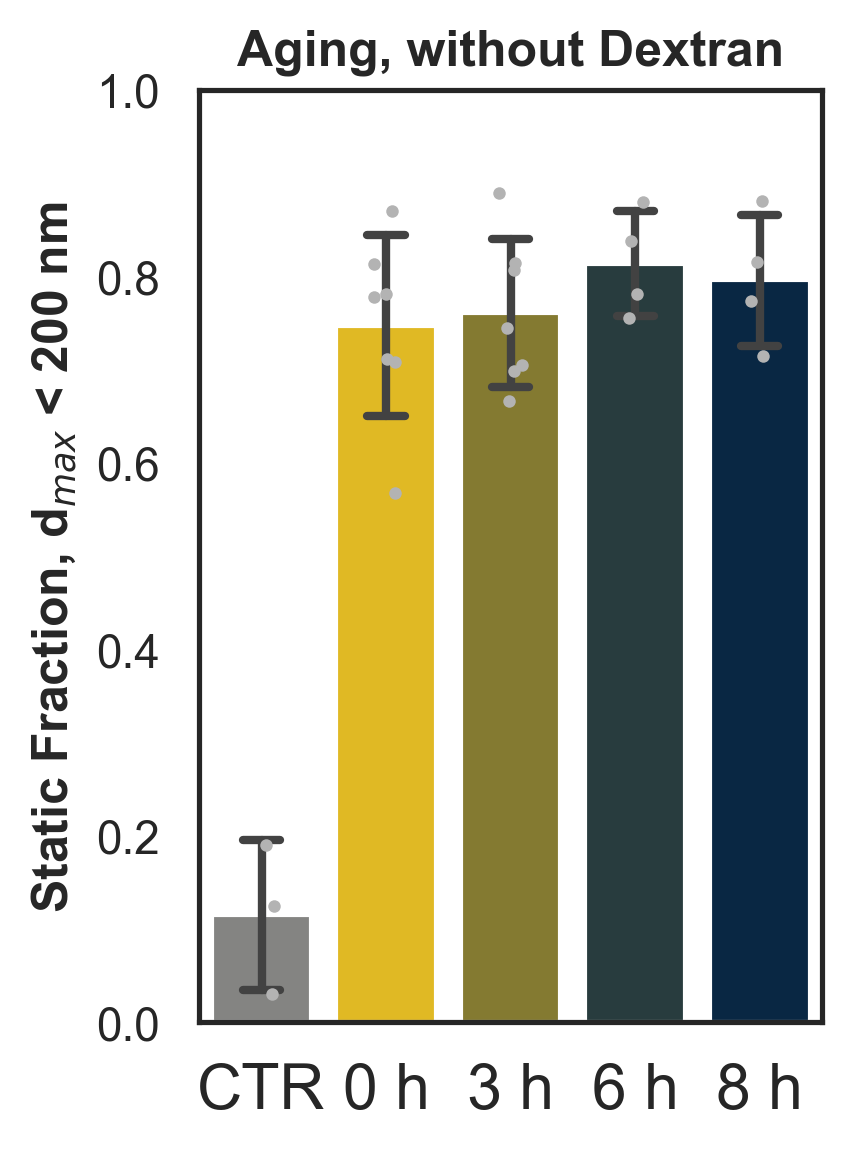

In [6]:
plt.figure(figsize=(3, 4), dpi=300)
data = df_plot[df_plot["variable"] == "Static Fraction"]
data = data[data["label"].isin(['FL in Buffer', '0Dex, -, 0h', '0Dex, -, 3h', '0Dex, -, 6h', '0Dex, -, 8h'])]
ax = sns.barplot(
    data=data,
    x="label",
    y="value",
    palette=palette_1,
    errorbar="sd",
    errwidth=2,
    capsize=0.3,
)
ax = sns.stripplot(
    data=data,
    x="label",
    y="value",
    color="0.7",
    size=3,
)
plt.title("Aging, without Dextran", weight="bold")
plt.ylim(0, 1)
plt.ylabel(r"Static Fraction, d$_{max}$ < 200 nm", weight="bold")
ax.set_xticklabels(["CTR", "0 h", "3 h", "6 h", "8 h"])
ax.xaxis.set_tick_params(labelsize=15, labelrotation=0)
plt.xlabel("")
plt.tight_layout()
plt.savefig("F_static_noDex.png", format="png")
plt.show()

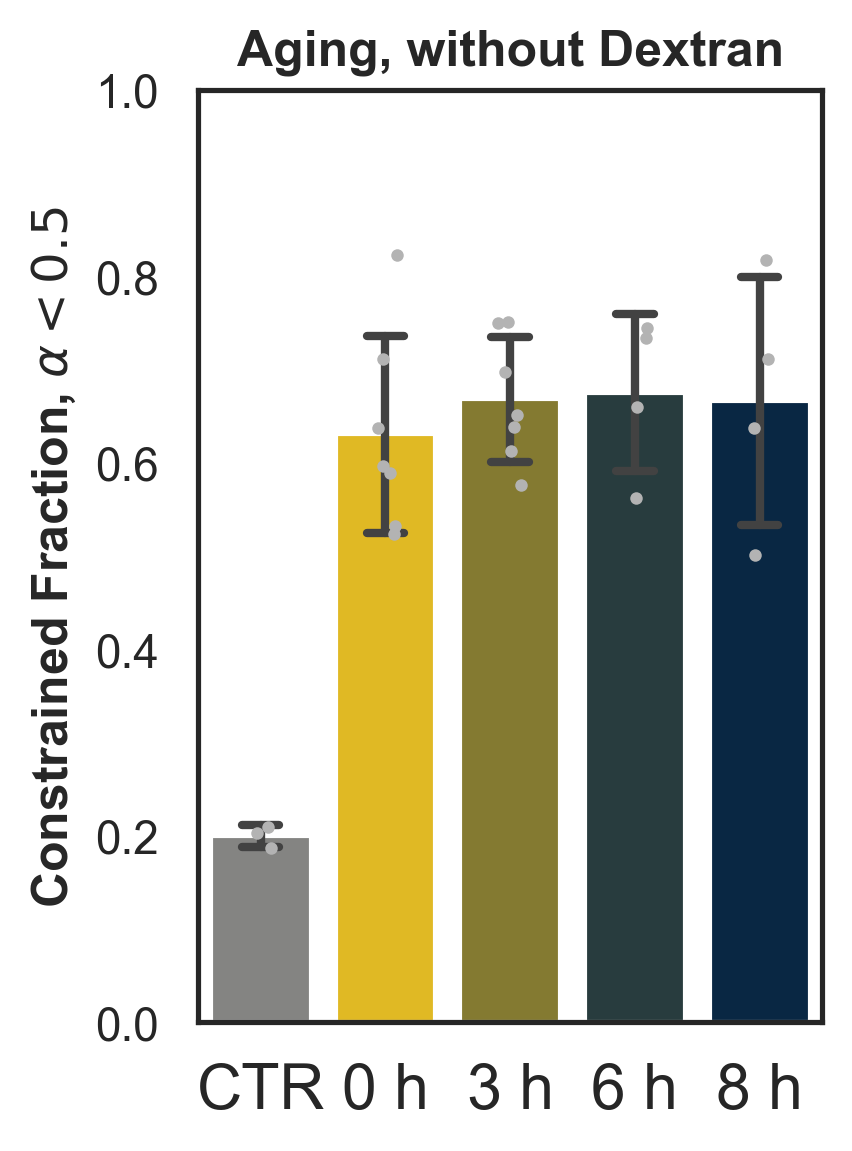

In [7]:
plt.figure(figsize=(3, 4), dpi=300)
data = df_plot[df_plot["variable"] == "Constrained Fraction"]
data = data[data["label"].isin(['FL in Buffer', '0Dex, -, 0h', '0Dex, -, 3h', '0Dex, -, 6h', '0Dex, -, 8h'])]
ax = sns.barplot(
    data=data,
    x="label",
    y="value",
    palette=palette_1,
    errorbar="sd",
    errwidth=2,
    capsize=0.3,
)
ax = sns.stripplot(
    data=data,
    x="label",
    y="value",
    color="0.7",
    size=3,
)
plt.title("Aging, without Dextran", weight="bold")
plt.ylim(0, 1)
plt.ylabel(r"Constrained Fraction, $\alpha < 0.5$", weight="bold")
ax.set_xticklabels(["CTR", "0 h", "3 h", "6 h", "8 h"])
ax.xaxis.set_tick_params(labelsize=15, labelrotation=0)
plt.xlabel("")
plt.tight_layout()
plt.savefig("F_constrained_noDex.png", format="png")
plt.show()

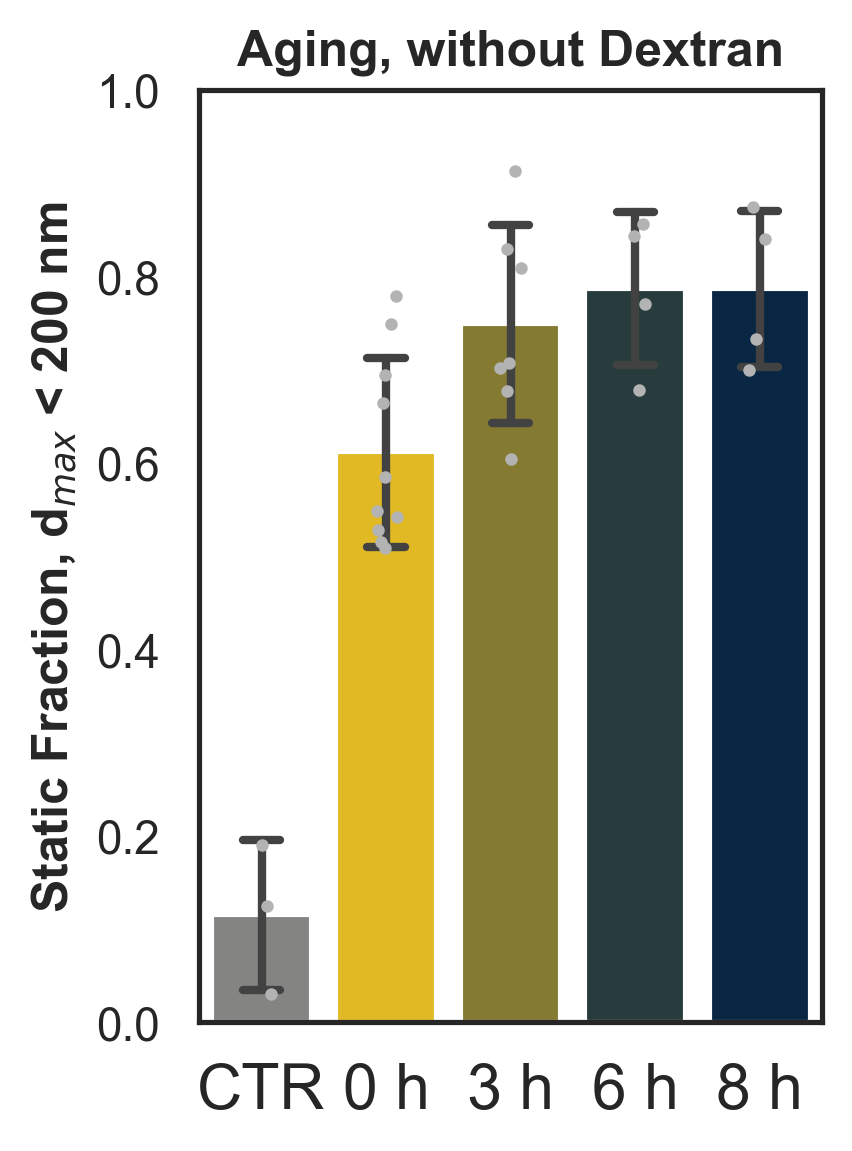

In [8]:
plt.figure(figsize=(3, 4), dpi=300)
data = df_plot[df_plot["variable"] == "Static Fraction"]
data = data[data["label"].isin(['FL in Buffer', '10Dex, -, 0h', '10Dex, -, 3h', '10Dex, -, 6h', '10Dex, -, 8h'])]
ax = sns.barplot(
    data=data,
    x="label",
    y="value",
    palette=palette_1,
    errorbar="sd",
    errwidth=2,
    capsize=0.3,
)
ax = sns.stripplot(
    data=data,
    x="label",
    y="value",
    color="0.7",
    size=3,
)
plt.title("Aging, without Dextran", weight="bold")
plt.ylim(0, 1)
plt.ylabel(r"Static Fraction, d$_{max}$ < 200 nm", weight="bold")
ax.set_xticklabels(["CTR", "0 h", "3 h", "6 h", "8 h"])
ax.xaxis.set_tick_params(labelsize=15, labelrotation=0)
plt.xlabel("")
plt.tight_layout()
plt.savefig("F_static_10Dex.png", format="png")
plt.show()

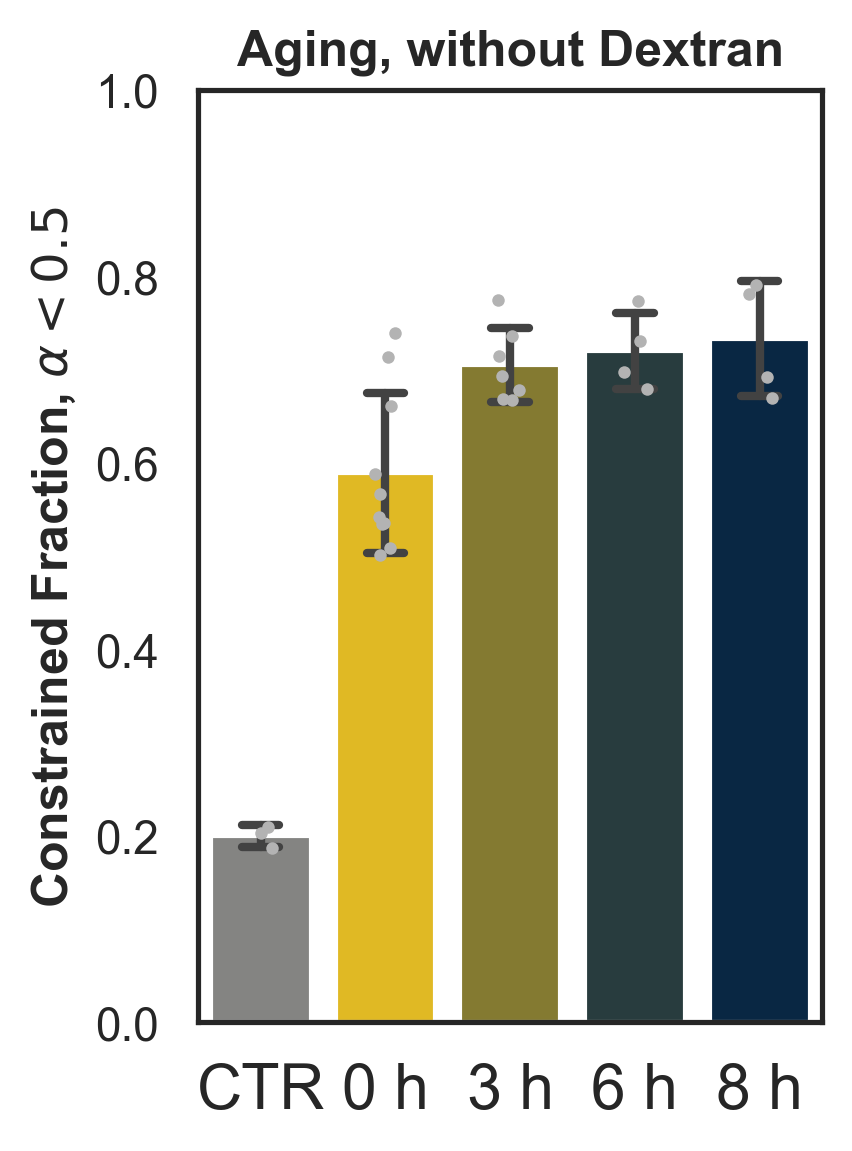

In [9]:
plt.figure(figsize=(3, 4), dpi=300)
data = df_plot[df_plot["variable"] == "Constrained Fraction"]
data = data[data["label"].isin(['FL in Buffer', '10Dex, -, 0h', '10Dex, -, 3h', '10Dex, -, 6h', '10Dex, -, 8h'])]
ax = sns.barplot(
    data=data,
    x="label",
    y="value",
    palette=palette_1,
    errorbar="sd",
    errwidth=2,
    capsize=0.3,
)
ax = sns.stripplot(
    data=data,
    x="label",
    y="value",
    color="0.7",
    size=3,
)
plt.title("Aging, without Dextran", weight="bold")
plt.ylim(0, 1)
plt.ylabel(r"Constrained Fraction, $\alpha < 0.5$", weight="bold")
ax.set_xticklabels(["CTR", "0 h", "3 h", "6 h", "8 h"])
ax.xaxis.set_tick_params(labelsize=15, labelrotation=0)
plt.xlabel("")
plt.tight_layout()
plt.savefig("F_constrained_10Dex.png", format="png")
plt.show()

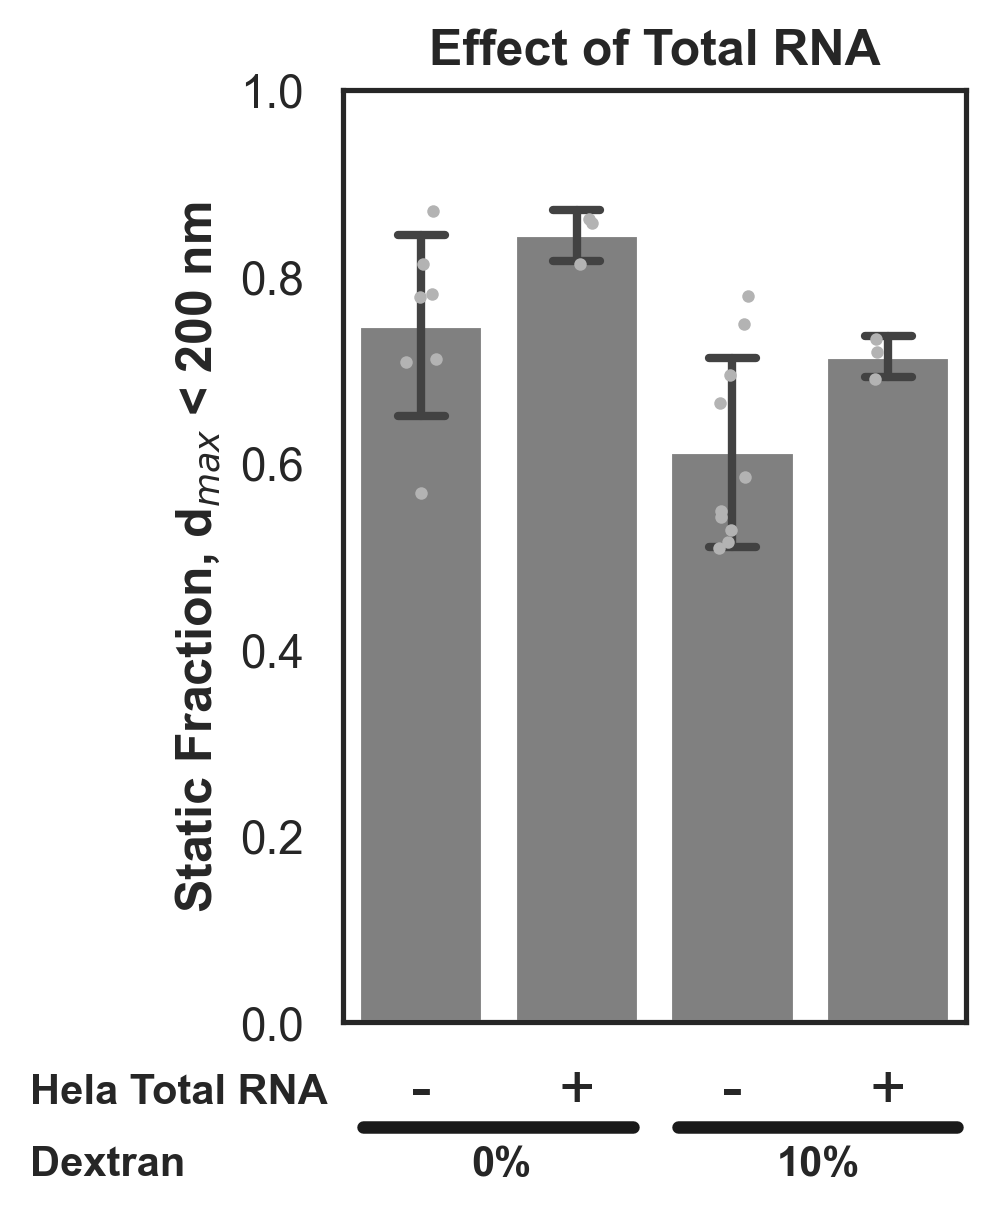

In [10]:
fig = plt.figure(figsize=(3, 4), dpi=300)
data = df_plot[df_plot["variable"] == "Static Fraction"]
data = data[data["label"].isin(['0Dex, -, 0h', '0Dex, Hela, 0h', '10Dex, -, 0h', '10Dex, Hela, 0h'])]
ax = sns.barplot(
    data=data,
    x="label",
    y="value",
    color="gray",
    errorbar="sd",
    errwidth=2,
    capsize=0.3,
)
ax = sns.stripplot(
    data=data,
    x="label",
    y="value",
    color="0.7",
    size=3,
)
plt.title("Effect of Total RNA", weight="bold")
plt.ylim(0, 1)
plt.ylabel(r"Static Fraction, d$_{max}$ < 200 nm", weight="bold")
ax.set_xticklabels(["-", "+", "-", "+"])
ax.xaxis.set_tick_params(labelsize=15)
plt.xlabel("")

fig.text(-.1, 0.06, "Hela Total RNA", fontsize=10, weight="bold")

line_y = 0.04
fig.add_artist(lines.Line2D([0.27, 0.57], [line_y, line_y], c="k", lw=3))
fig.add_artist(lines.Line2D([0.62, 0.93], [line_y, line_y], c="k", lw=3))


fig.text(-.1, 0, "Dextran", fontsize=10, weight="bold")
fig.text(.39, 0, "0%", fontsize=10, weight="bold")
fig.text(.73, 0, "10%", fontsize=10, weight="bold")

plt.tight_layout()
plt.savefig("F_static_compareRNA.png", format="png")
plt.show()

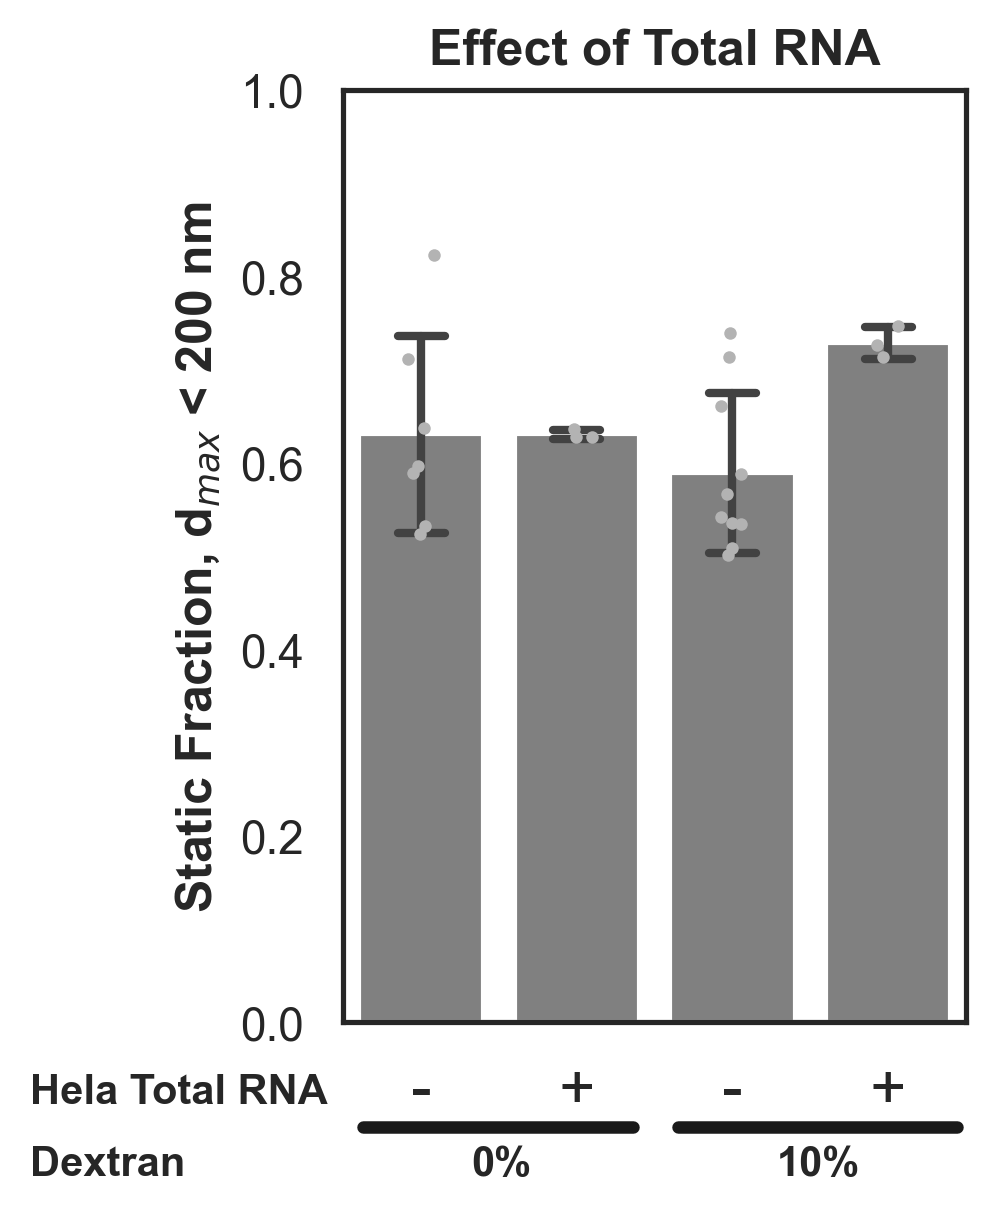

In [11]:
fig = plt.figure(figsize=(3, 4), dpi=300)
data = df_plot[df_plot["variable"] == "Constrained Fraction"]
data = data[data["label"].isin(['0Dex, -, 0h', '0Dex, Hela, 0h', '10Dex, -, 0h', '10Dex, Hela, 0h'])]
ax = sns.barplot(
    data=data,
    x="label",
    y="value",
    color="gray",
    errorbar="sd",
    errwidth=2,
    capsize=0.3,
)
ax = sns.stripplot(
    data=data,
    x="label",
    y="value",
    color="0.7",
    size=3,
)
plt.title("Effect of Total RNA", weight="bold")
plt.ylim(0, 1)
plt.ylabel(r"Static Fraction, d$_{max}$ < 200 nm", weight="bold")
ax.set_xticklabels(["-", "+", "-", "+"])
ax.xaxis.set_tick_params(labelsize=15)
plt.xlabel("")

fig.text(-.1, 0.06, "Hela Total RNA", fontsize=10, weight="bold")

line_y = 0.04
fig.add_artist(lines.Line2D([0.27, 0.57], [line_y, line_y], c="k", lw=3))
fig.add_artist(lines.Line2D([0.62, 0.93], [line_y, line_y], c="k", lw=3))


fig.text(-.1, 0, "Dextran", fontsize=10, weight="bold")
fig.text(.39, 0, "0%", fontsize=10, weight="bold")
fig.text(.73, 0, "10%", fontsize=10, weight="bold")

plt.tight_layout()
plt.savefig("F_constrained_compareRNA.png", format="png")
plt.show()